<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/cda-2022/blob/main/notebooks/cda_4_gof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

### Python libraries

In [67]:
import scipy.stats as st
from scipy.optimize import minimize
import numpy as np
import pandas as pd

## Setup R via Python

In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("vcd")
install.packages("fitdistrplus")

In [7]:
%%R
library(vcd)
library(fitdistrplus)

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: survival



## Setup Julia via Python

In [ ]:
%%bash
wget -q https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz
tar zxvf julia-1.7.2-linux-x86_64.tar.gz
## python's module
pip install julia

In [27]:
import julia
julia.install(julia = "/content/julia-1.7.2/bin/julia")
from julia import Julia
jl = Julia(runtime="/content/julia-1.7.2/bin/julia",compiled_modules=False)
%load_ext julia.magic


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.

PyCall is setup for non-default Julia runtime (executable) `/content/julia-1.7.2/bin/julia`.
To use this Julia runtime, PyJulia has to be initialized first by
    from julia import Julia
    Julia(runtime='/content/julia-1.7.2/bin/julia')


Initializing Julia interpreter. This may take some time...


/usr/local/lib/python3.7/dist-packages/julia/magic.py:166: UserWarning: Incompatible upstream libraries. Got ImportError: No module named 'prompt_toolkit.lexers'
  warnings.warn(template.format(err))
/usr/local/lib/python3.7/dist-packages/julia/magic.py:174: UserWarning: Incompatible upstream libraries. Got ImportError: cannot import name 'Completion' from 'IPython.core.completer' (/usr/local/lib/python3.7/dist-packages/IPython/core/completer.py)
  warnings.warn(template.format(err))


In [ ]:
%%julia
using Pkg
Pkg.add("Distributions")
Pkg.add("Optim")
Pkg.add("HypothesisTests")
Pkg.add("StatsBase")
using Distributions
using Random
using HypothesisTests
using Optim
using StatsBase

In [29]:
%%julia
Pkg.status()

      Status `~/.julia/environments/v1.7/Project.toml`
  [31c24e10] Distributions v0.25.51
  [09f84164] HypothesisTests v0.10.8
  [429524aa] Optim v1.6.2
  [438e738f] PyCall v1.93.1
  [2913bbd2] StatsBase v0.33.16


## Solution in R

In [23]:
%%R
set.seed(1)
n <- 10000
x <- rnbinom(n, mu = 3, size = 2)
fitdistr(x = x, densfun = "negative binomial")

      size          mu    
  2.01336939   3.00049449 
 (0.05148793) (0.02733434)


In [12]:
%%R
cat(x, sep = "\n", file = "nb_sim.txt")

In [ ]:
%%R
gof_nb <- goodfit(x, "nbinomial")
gof_po <- goodfit(x, "poisson")
summary(gof_nb)
summary(gof_po)


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df  P(> X^2)
Likelihood Ratio 21.27568 18 0.2657337

	 Goodness-of-fit test for poisson distribution

                      X^2 df P(> X^2)
Likelihood Ratio 5112.284 19        0


Note that we may use $\chi^2$ test but the degrees of freedom and p-value is incorrect as it does not account for number of parameters.

In [ ]:
%%R
chisq.test(x = gof_nb$observed, p = gof_nb$fitted/sum(gof_nb$fitted)) 
## should be 15 istead of 17


	Chi-squared test for given probabilities

data:  gof_nb$observed
X-squared = 15.718, df = 17, p-value = 0.5439



In [ ]:
%%R
pchisq(15.718, 15, lower.tail = FALSE)

[1] 0.4010371


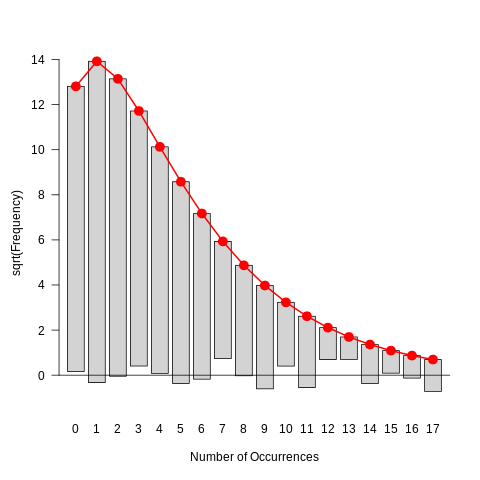

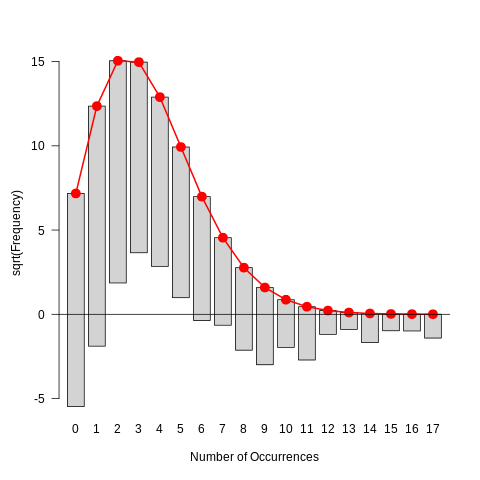

In [ ]:
%%R
rootogram(gof_nb)
rootogram(gof_po)

## Solution in Python

Python uses a different specification of negative binomial than we specified in R so we need to rewrite it as follows: 

$$
p = \frac{\text{size}}{\text{size} + \mu}.
$$

In [65]:
np.random.seed(1)
N = 1000
x = st.nbinom(n = 2, p = 2/(2+3)).rvs(N)
np.mean(x)

3.09

However, these pseudo-random numbers are not the same as in R. So, to make our example comparable with R, we read data generated from R that was saved to text file.

In [66]:
x = np.loadtxt("nb_sim.txt", dtype = np.int64)
np.mean(x)

3.0006

Optimization using pmf function

In [68]:
def pdf_nbinom(par, x):
  pdfnbinom = st.nbinom(par[0],par[1]).logpmf(x)
  return -np.sum(pdfnbinom)

res = minimize(fun=pdf_nbinom, x0=[2, 0.5], args = (x), method = "Nelder-Mead")
res

 final_simplex: (array([[2.01357331, 0.40157875],
       [2.0136646 , 0.40158661],
       [2.01348695, 0.40156478]]), array([22061.74799012, 22061.74799024, 22061.74799191]))
           fun: 22061.747990122178
       message: 'Optimization terminated successfully.'
          nfev: 76
           nit: 40
        status: 0
       success: True
             x: array([2.01357331, 0.40157875])

We may use statsmodels but this require some workaround to get the NB parameters.

In [24]:
ones = np.ones_like(x)
fitnb = sm.NegativeBinomial(x,ones).fit()
print(fitnb.summary())

Optimization terminated successfully.
         Current function value: 2.206175
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                10000
Model:               NegativeBinomial   Df Residuals:                     9999
Method:                           MLE   Df Model:                            0
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:               7.998e-12
Time:                        07:50:46   Log-Likelihood:                -22062.
converged:                       True   LL-Null:                       -22062.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0988      0.009    120.6

Note that in this output `const` is $log(\mu)$ and $\alpha$ can be used to estimate $p$.

In [25]:
mu = np.exp(fitnb.params[0])
alpha = fitnb.params[1]
p = 1/(1 + mu*alpha)
size = mu*p/(1-p)
mu, p, size

(3.0006, 0.40157923788470296, 2.013597684908997)

Rootograms are not available in python. There are some scripts that recreate this plot using `matplotlib`, see

https://stackoverflow.com/questions/38252879/how-to-plot-a-hanging-rootogram-in-python



## Solution in Julia

In [30]:
%%julia
Random.seed!(123)
n = 1000
x = rand(NegativeBinomial(2, 2/(2+3)), n)
mean(x)

3.026

However, these pseudo-random numbers are not the same as in R. So, to make our example comparable with R, we read data generated from R that was saved to text file.

In [44]:
%%julia
x = readlines("nb_sim.txt")
x = parse.(Int, x)

array([3, 1, 1, ..., 3, 3, 3], dtype=int64)

In [45]:
%%julia
function llnb(par, data)
  ll = logpdf.(NegativeBinomial(par[1], par[2]), data)
  return -sum(ll)
end

res = optimize(par -> llnb(par, x), [2, 0.5])
res.minimizer

array([2.01360006, 0.40157958])

Goodness of fit statistics

In [62]:
%%julia
x_uniq_dict = sort(countmap(x))
x_uniq_vals = Int.(keys(x_uniq_dict))
x_uniq_counts = Int.(values(x_uniq_dict))
params = res.minimizer
est_cdf = cdf.(NegativeBinomial(params[1], params[2]), x_uniq_vals[1:(end-1)])
est_pdf = diff(vcat(0,est_cdf,1))

array([0.15927753, 0.19192614, 0.17305978, 0.13855283, 0.10392296,
       0.0747967 , 0.05232131, 0.03584385, 0.02416737, 0.01609102,
       0.01060521, 0.00693116, 0.0044981 , 0.00290163, 0.00186211,
       0.00118962, 0.00075699, 0.00048001, 0.00030342, 0.00031152,
       0.00020076])

```julia
julia> ChisqTest(x_uniq_counts, est_pdf)
Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.159278, 0.191926, 0.17306, 0.138553, 0.103923, 0.0747967, 0.0523213, 0.0358438, 0.0241674, 0.016091  …  0.00693116, 0.0044981, 0.00290163, 0.00186211, 0.00118962, 0.000756992, 0.000480009, 0.000303422, 0.000311515, 0.000200757]
    point estimate:          [0.1583, 0.1969, 0.1699, 0.1356, 0.1025, 0.0748, 0.0565, 0.0357, 0.0244, 0.0164  …  0.0054, 0.0045, 0.0024, 0.0023, 0.0012, 0.0011, 0.0006, 0.0002, 0.0001, 0.0001]
    95% confidence interval: [(0.1491, 0.1676), (0.1877, 0.2062), (0.1607, 0.1792), (0.1264, 0.1449), (0.0933, 0.1118), (0.0656, 0.0841), (0.0473, 0.0658), (0.0265, 0.045), (0.0152, 0.0337), (0.0072, 0.0257)  …  (0.0, 0.0147), (0.0, 0.0138), (0.0, 0.0117), (0.0, 0.0116), (0.0, 0.0105), (0.0, 0.0104), (0.0, 0.0099), (0.0, 0.0095), (0.0, 0.0094), (0.0, 0.0094)]

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.7268

Details:
    Sample size:        10000
    statistic:          15.834662044034829
    degrees of freedom: 20
    residuals:          [-0.244937, 1.13534, -0.759555, -0.793288, -0.441404, 0.00120639, 1.82684, -0.0759791, 0.149644, 0.243582  …  -1.83915, 0.00283987, -0.931235, 1.01477, 0.0300909, 1.24669, 0.547676, -0.593732, -1.1984, -0.711114]
    std. residuals:     [-0.267133, 1.26299, -0.835261, -0.854705, -0.466298, 0.00125421, 1.87659, -0.0773785, 0.151485, 0.245566  …  -1.84556, 0.00284628, -0.932589, 1.01571, 0.0301088, 1.24716, 0.547808, -0.593823, -1.19859, -0.711185]
```

Note that p-value is calculated wrongly as correct df is 18 not 20. So correct p-value is: 

In [59]:
%%julia
1-cdf(Chisq(18), 15.834662044034829)

0.6040851660737778